# verify-c-common Empirical Results
This notebook is an alternative report of empirical results made on a case study paper "Verifying Verified Code".


## Part one: Benckmark Prepration and Setup


|  | CBMC | SeaHorn | KLEE | libfuzzer         
| :- |:------------- | :------------- | :------------- | :-------------
| # Benchmark Covered| 168  | 168 | 153 | 78
| Timeout | 2000 seconds| 2000 seconds | 2000 seconds | --
| Total Running Time | 6475 seconds | 691 seconds | 8577 seconds | --
| Benchmark Source | [aws-c-common](https://github.com/awslabs/aws-c-common/tree/main/verification/cbmc/proofs) | [verify-c-common](https://github.com/seahorn/verify-c-common/tree/master/seahorn/jobs) | [verify-c-common](https://github.com/seahorn/verify-c-common/tree/master/seahorn/jobs)| [verify-c-common](https://github.com/seahorn/verify-c-common/tree/master/seahorn/jobs)
| Options | Inidividual: <br/>`make results ` <br/> Unit Test: <br/> a python scripts used to traverse all harnnesses  | Inidividual: <br/>`./verify [options] <BC_FILE_NAME> ` <br/> Unit Test: <br/> `ctest -D ExperimentalTest -R . --timeout 2000` | Inidividual: <br/>`klee --libc=uclibc --exit-on-error <KLEE_BC_FILE_NAME> ` <br/> Unit Test: <br/> `ctest -D ExperimentalTest -R klee_ --timeout 2000` | --
| Results | [aws-cbmc.csv](https://github.com/seahorn/verify-c-common/tree/master/res/aws-cbmc.csv) | [seahorn.csv](https://github.com/seahorn/verify-c-common/tree/master/res/seahorn.csv) | [klee.csv](https://github.com/seahorn/verify-c-common/tree/master/res/klee.csv) | [Coverage report](https://seahorn.github.io/verify-c-common/fuzzing_coverage/index.html)


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import copy
from matplotlib.backends.backend_pdf import PdfPages
from google.colab import files

# Do not limit number of rows displayed
pd.set_option('display.max_rows', None)

In [2]:
# Include data files
SEAHORN_CSV = 'https://raw.githubusercontent.com/seahorn/verify-c-common/master/res/seahorn.csv'
KLEE_CSV = 'https://raw.githubusercontent.com/seahorn/verify-c-common/master/res/klee.csv'
CBMC_CSV = 'https://raw.githubusercontent.com/seahorn/verify-c-common/master/res/aws-cbmc.csv'
LOC_CSV = 'https://raw.githubusercontent.com/seahorn/verify-c-common/master/res/loc.csv'

In [3]:
# The result for normal mode...
seahorn_norm = pd.read_csv(SEAHORN_CSV)
seahorn_norm.loc[seahorn_norm['Timing'] == 'Completed', 'Timing'] = 0.0
seahorn_norm['Timing'] = seahorn_norm['Timing'].astype(float)
# The result for klee...
klee = pd.read_csv(KLEE_CSV)
# The result for aws/cbmc...
aws_cbmc = pd.read_csv(CBMC_CSV)
# The result for loc...
jobs_loc = pd.read_csv(LOC_CSV)

# Rename column's name
cbmc_time = aws_cbmc[['bench name', 'total times (s)']].rename(columns = {'total times (s)': 'CBMC time (s)', 'bench name': 'job name'})
seahorn_time = seahorn_norm[['Name', 'Timing']].rename(columns = {'Timing':'Seahorn normal time (s)'})
klee_time = klee[['Name', 'Timing']].rename(columns = {'Timing': 'Klee time (s)'})
jobs_loc = jobs_loc.rename(columns = {'LOC': 'loc'})
# Rename job's name
seahorn_time['job name'] = seahorn_time['Name'].map(lambda name : 'aws_{}'.format(name[:-11]))
klee_time['job name'] = klee_time['Name'].map(lambda name : 'aws_{}'.format(name[5:-5]))
jobs_loc['job name'] = jobs_loc['Name'].map(lambda name : 'aws_{}'.format(name))
# Drop uncessary columns
seahorn_time = seahorn_time.drop(columns=['Name'])
klee_time = klee_time.drop(columns=['Name'])

# Merge results into one dataframe and rearrange it
sea_cbmc = pd.merge(seahorn_time, cbmc_time, how='outer', on='job name')
sea_cbmc_klee = pd.merge(sea_cbmc, klee_time, how='outer', on='job name')
comb_loc = pd.merge(sea_cbmc_klee, jobs_loc, how='outer', on='job name')
combined = comb_loc[['job name', 'loc', 'CBMC time (s)', 'Seahorn normal time (s)', 'Klee time (s)']]

# Remove unwanted harnesses res
drop_harness_lst = ['aws_hash_iter_begin_done', 'memcpy_using_uint64', 'memset_override_0', 
                    'memset_using_uint64', 'aws_hash_table_foreach_deep_loose', 
                    'aws_byte_buf_eq2', 'aws_hash_table_foreach_deep_precise']
for drop_harn in drop_harness_lst:
  idx = combined.index[combined['job name'] == drop_harn].tolist()
  combined = combined.drop(idx)
  # combined.drop([combined.loc[combined['job name'] == drop_harn].index[0]], inplace=True)

# Save loc as int
combined.loc[:,'loc'] = combined.loc[:,'loc'].astype(int)

# Reindex
combined.index = np.arange(len(combined.index))

# Output data combined
combined

,job name,loc,CBMC time (s),Seahorn normal time (s),Klee time (s)
0,aws_add_size_checked,40,3.444,0.624538,0.740112
1,aws_add_size_saturating,37,3.447,0.549630,0.811040
2,aws_mul_size_checked,39,3.460,0.733943,0.857620
3,aws_mul_size_saturating,38,5.509,0.761364,1.450430
4,aws_is_power_of_two,11,3.443,0.444965,0.718919
5,aws_round_up_to_power_of_two,37,3.459,0.642792,0.794902
6,aws_nospec_mask,21,3.477,0.538230,NaN
7,aws_ptr_eq,10,3.504,0.500028,0.727793
8,aws_array_eq,100,5.630,2.196110,34.978200
9,aws_array_eq_c_str,112,5.534,1.700990,37.000100


In [4]:
def job_category(job):
  """
  A function to classify job by given name
  """
  if job.startswith('aws_hash_table'):
    return 'hash_table'
  elif job.startswith('aws_hash_iter'):
    return 'hash_iter'
  elif job.startswith('aws_hash_callback'):
    return 'hash_callback'
  elif job.startswith('aws_hash_'):
    return 'hash_table'
  elif job.startswith('aws_array_list'):
    return 'array_list'
  elif job.startswith('aws_array'):
    return 'array'
  elif job.startswith('aws_byte_buf'):
    return 'byte_buf'
  elif job.startswith('aws_byte_cursor'):
    return 'byte_cursor'
  elif job.startswith('aws_linked_list'):
    return 'linked_list'
  elif job.startswith('aws_string'):
    return 'string'
  elif job.startswith('aws_priority_queue'):
    return 'priority_queue'
  elif job.startswith('aws_ring_buffer'):
    return 'ring_buffer'
  elif job.startswith('mem'):
    return 'cbmc_mem'
  elif 'add' in job or 'mul' in job or 'power_of_two' in job:
    return 'arithmetic'
  else:
    return 'others'

combined.loc[:, 'category'] = combined.loc[:, 'job name'].map(job_category)

In [5]:
# Group data by category
combined_by_category = combined.groupby(by='category')
sum_table_1 = pd.DataFrame(combined.groupby(by='category').sum())
table_1 = pd.DataFrame(combined_by_category.describe(percentiles=[]).round(1))

# Get number of covered jobs for each tool
klee_covered_num = int(table_1['Klee time (s)']['count'].sum())
fuzz_covered_num = int(table_1['loc'].iloc[2:5, 0].sum())
total_num = int(table_1['loc']['count'].sum())
print(f'total number of unit proofs: {total_num}\n CBMC:{total_num}, Seahorn:{total_num}, klee: {klee_covered_num}, fuzz:{fuzz_covered_num}')

total number of unit proofs: 168
 CBMC:168, Seahorn:168, klee: 153, fuzz:76


In [6]:
# Show the result table
print(f'\t\t\t\t\tTable 1. Verification results for CBMC, SeaHorn, KLEE and libFuzzer.')
table_1

					Table 1. Verification results for CBMC, SeaHorn, KLEE and libFuzzer.


loc                      ... Klee time (s)                     
               count   mean   std    min  ...           std   min    50%     max
category                                  ...                                   
arithmetic       6.0   33.7  11.2   11.0  ...           0.3   0.7    0.8     1.5
array            4.0   97.5  14.2   78.0  ...           6.0  23.6   34.3    37.0
array_list      23.0  126.1  24.9   77.0  ...          49.3  13.4   41.3   164.3
byte_buf        29.0   97.1  33.4   50.0  ...         124.1  14.1   18.8   619.1
byte_cursor     24.0   98.4  28.7   47.0  ...          14.4   0.9    4.5    40.1
hash_callback    3.0  115.7  75.7   49.0  ...          45.5  14.7   72.7   104.5
hash_iter        4.0  177.0   8.7  169.0  ...           9.7  14.8   15.6    32.0
hash_table      19.0  172.9  77.9   36.0  ...         333.4   0.7   14.8  1307.3
linked_list     18.0  115.7  71.4   17.0  ...           0.1   0.6    0.7     0.9
others           2.0   15.5   7.8   10.0  ...           NaN   0.7    0.7     0.7
priority_queue  15.0  187.8  43.4  136.0  ...          11.6  17.7   50.7    51.3
ring_buffer      6.0  155.7  70.9   56.0  ...          26.4  14.2   60.4    73.5
string          15.0   87.6  46.4   11.0  ...         159.7  15.6  105.4   482.3

[13 rows x 24 columns]

## Part two: Running time per category for CBMC,  SeaHorn and KLEE

The following graph shows the running time results based on each category of jobs.

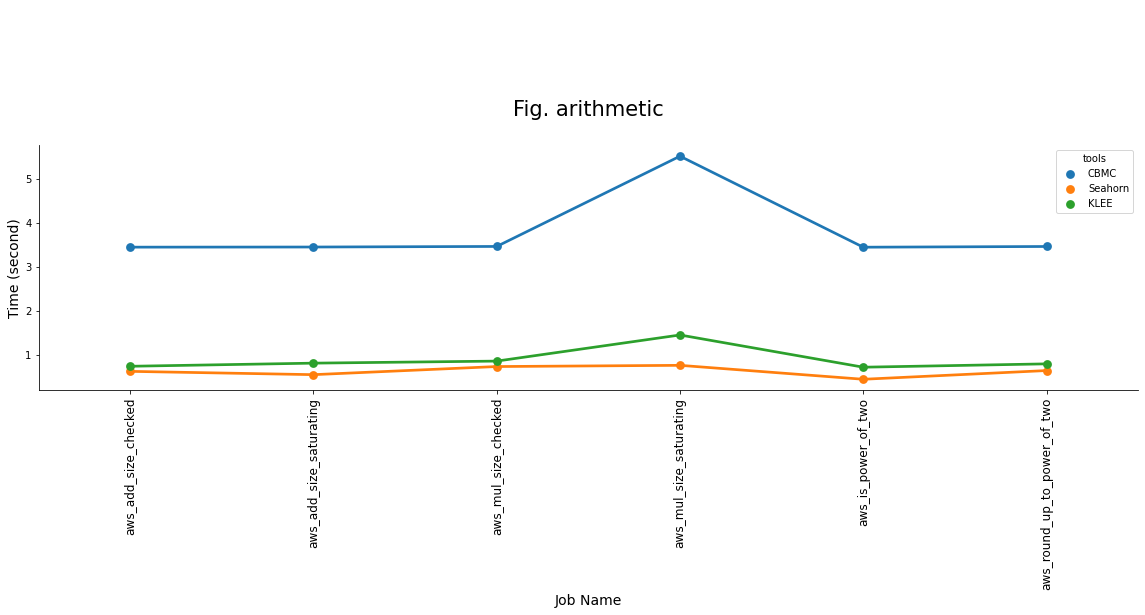

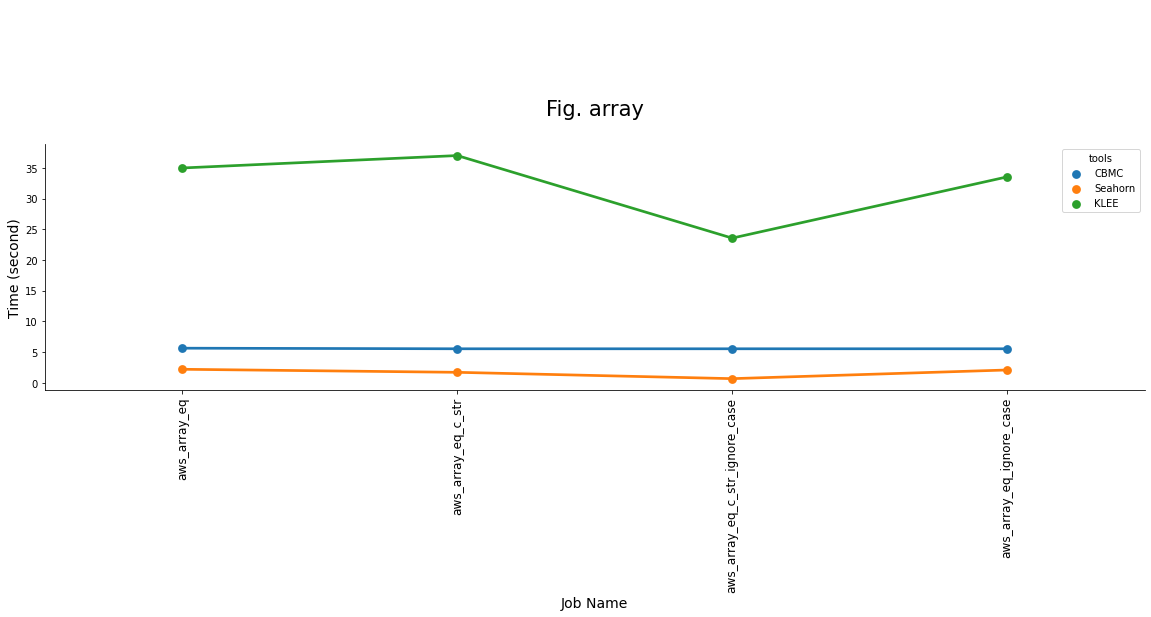

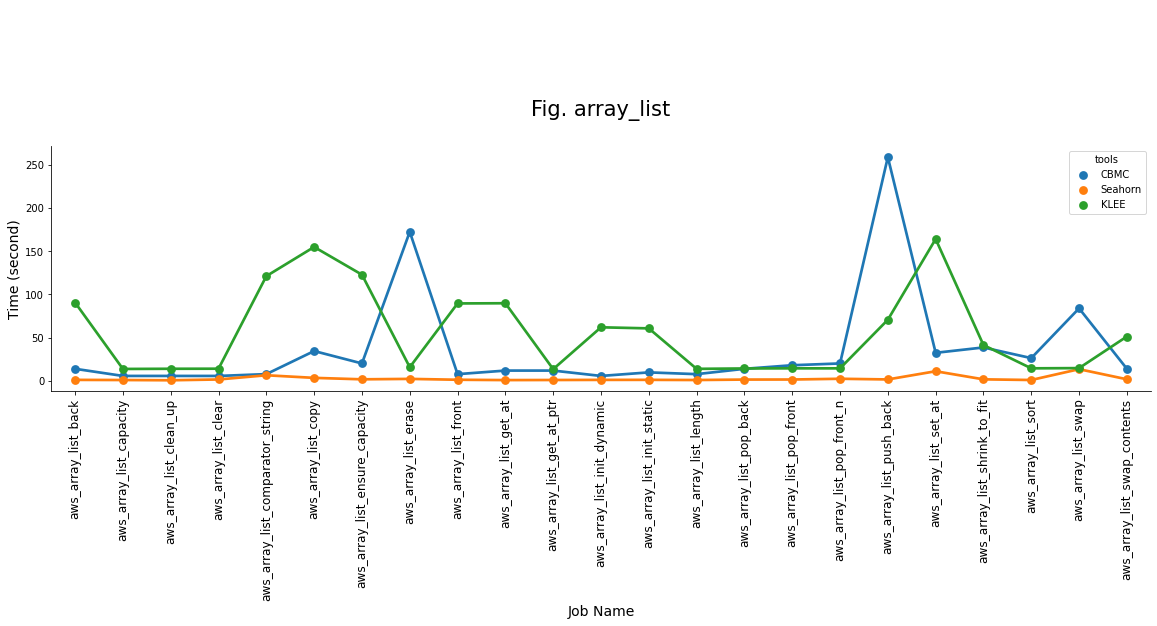

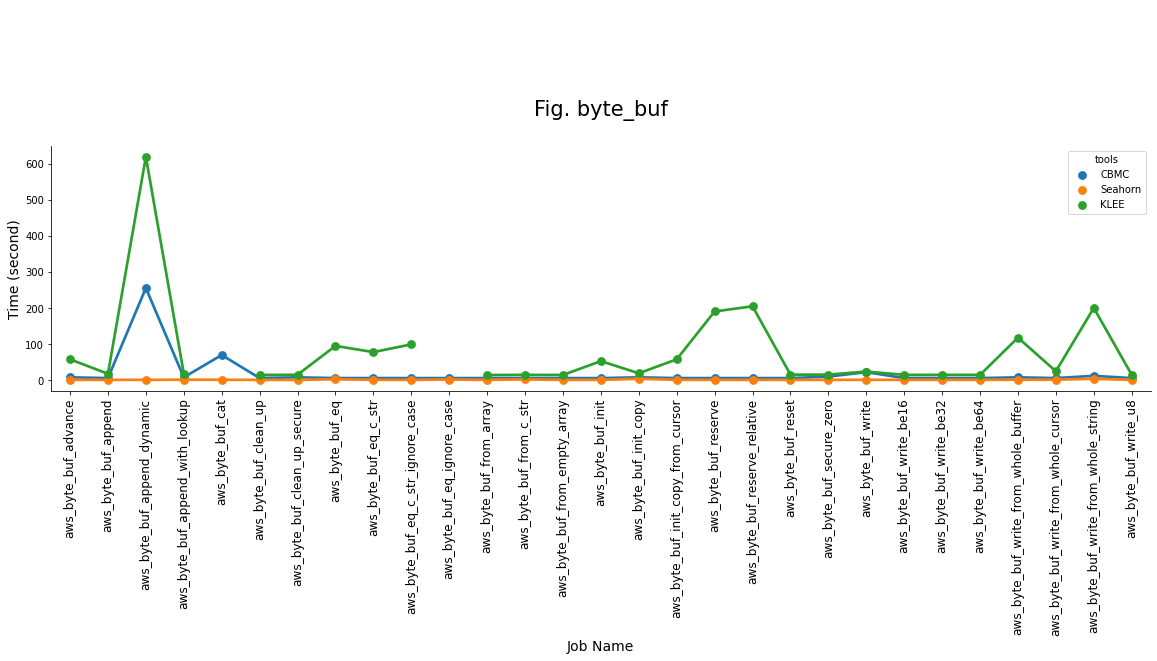

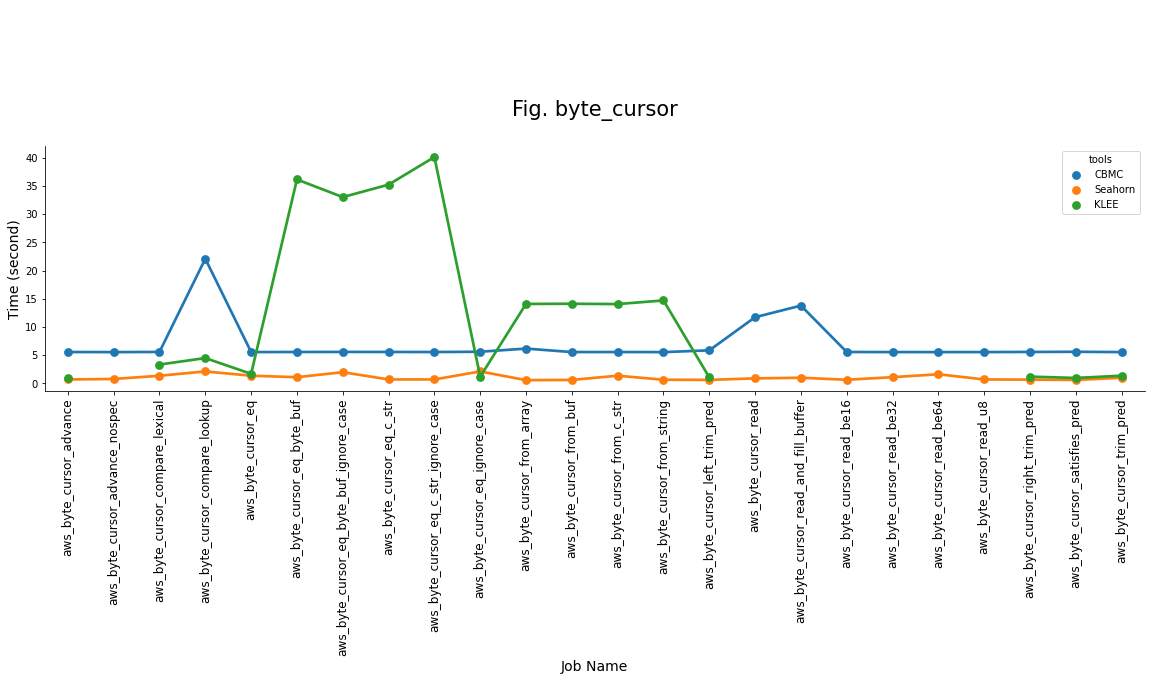

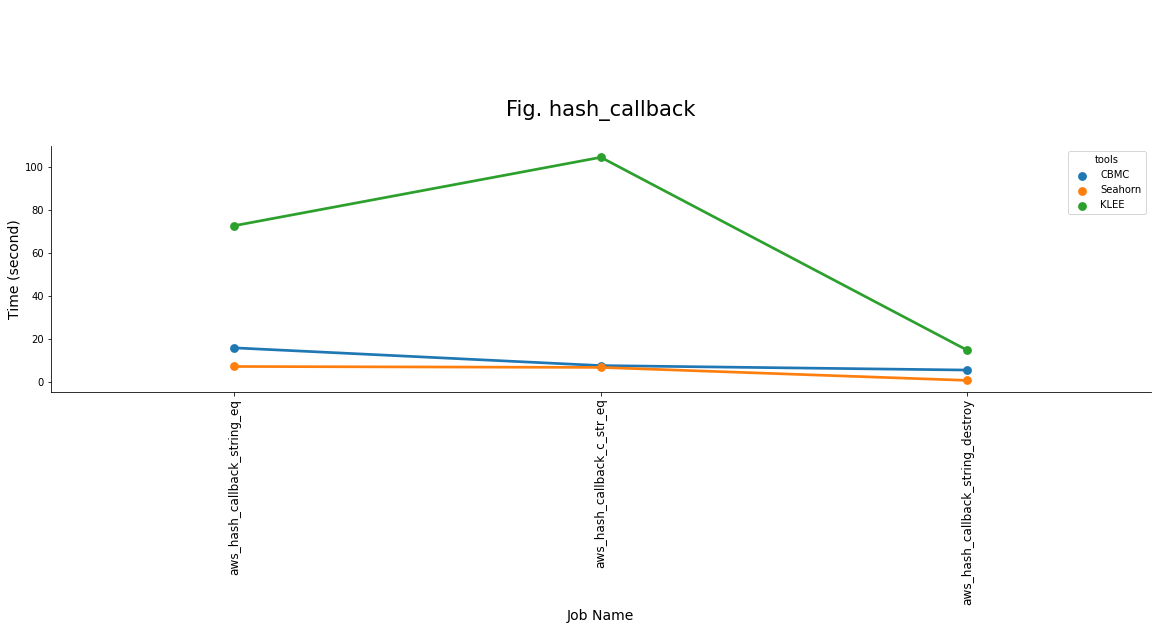

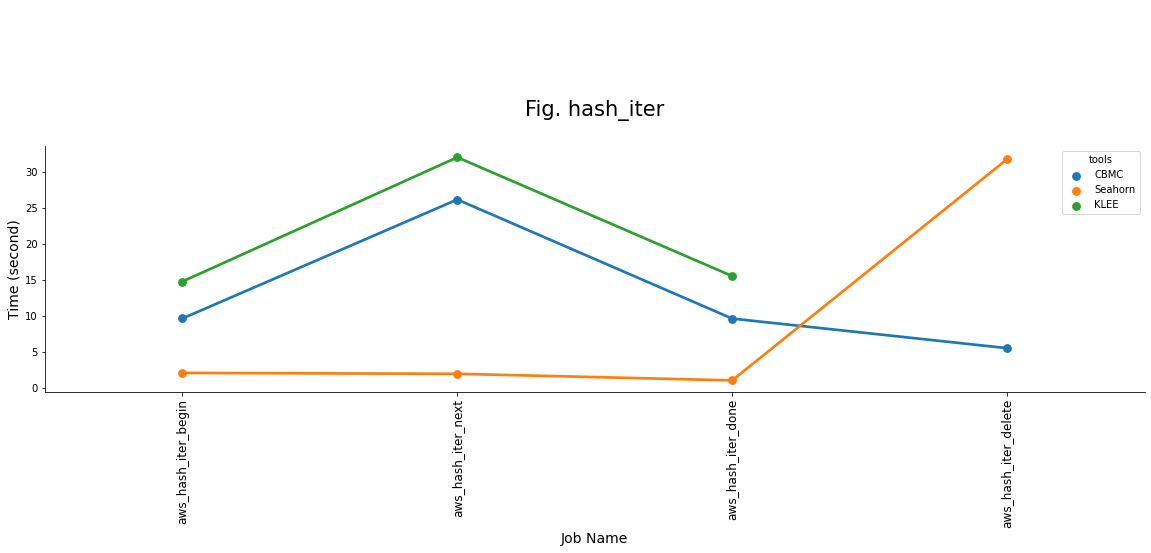

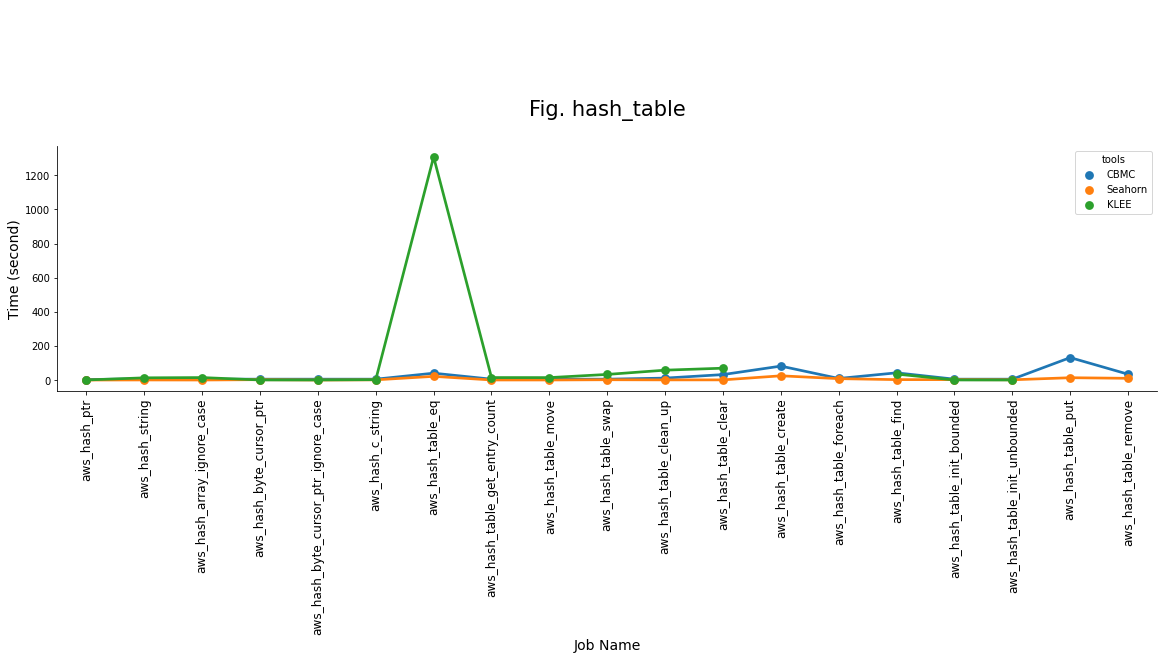

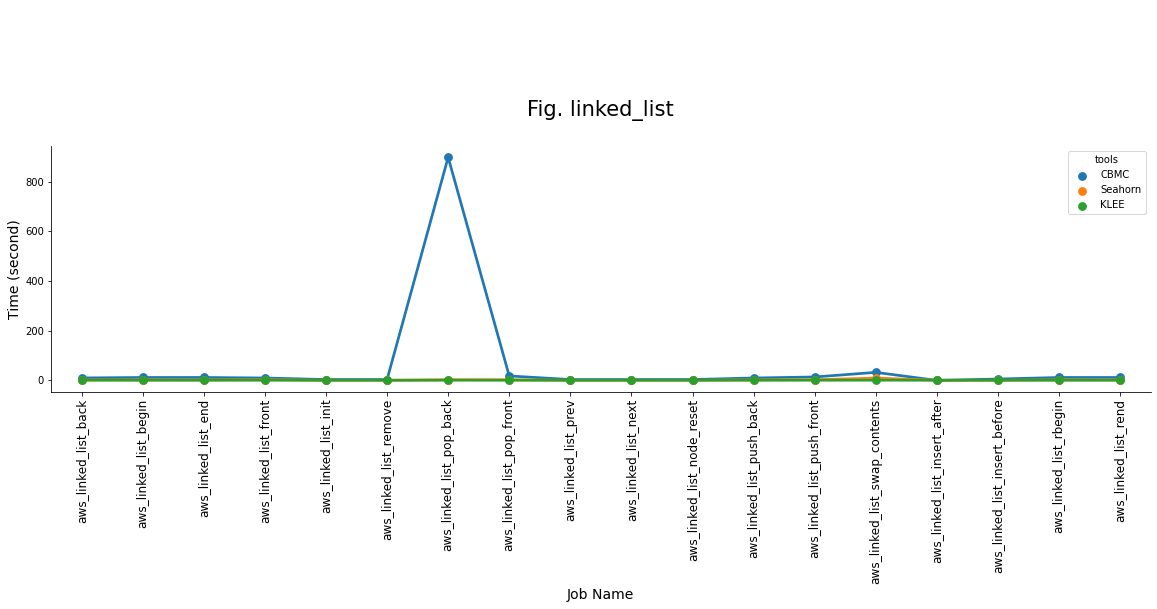

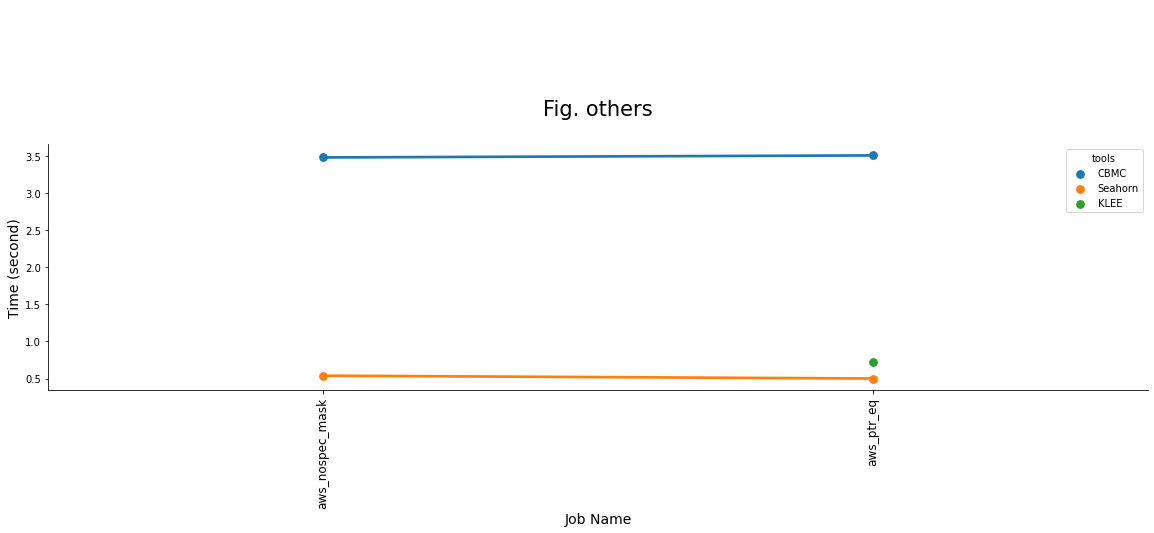

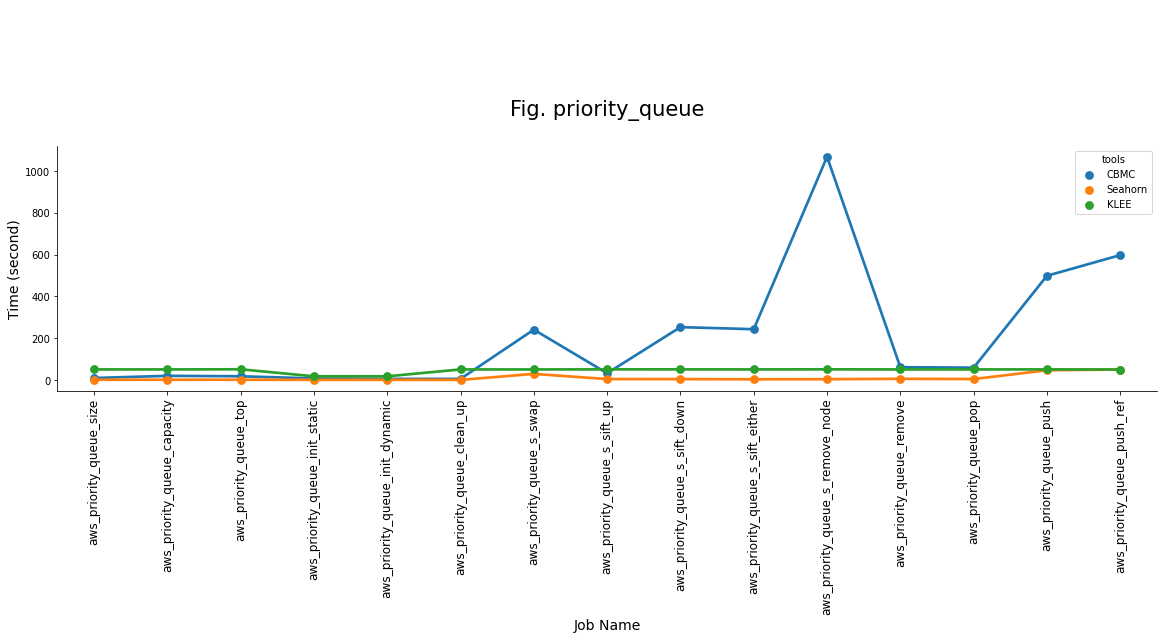

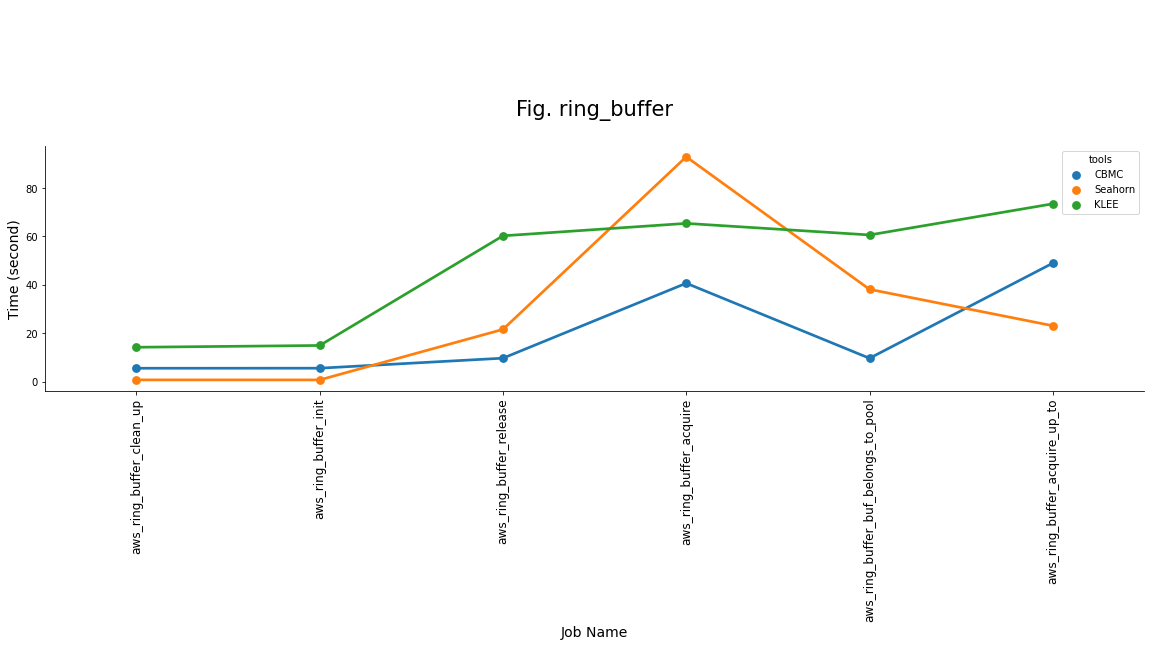

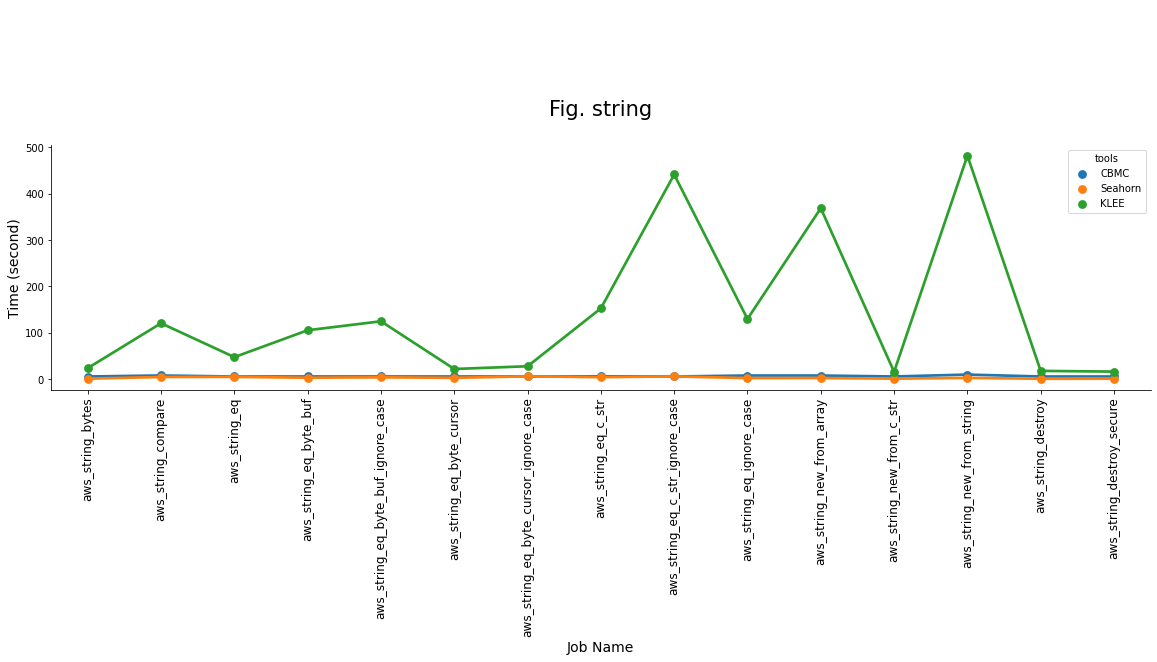

In [7]:
categories = combined_by_category.groups.keys()
sorted(categories)
YLIMS = 150 # Change the y limits here
for cat in categories:
  # For each category, melt data and draw a line graph with dots
  job_ids = combined_by_category.get_group(cat).index.values
  df = combined_by_category.get_group(cat).drop(columns=['category', 'loc'])
  df = df.rename(columns={"Seahorn normal time (s)": "Seahorn", "CBMC time (s)": "CBMC", "Klee time (s)": "KLEE"})
  df = df.melt('job name', var_name='tools',  value_name='time (s)')
  fig, ax = plt.subplots(figsize=(16,4))
  fig.tight_layout()
  # Uncomment the next line if you want to show detailed comparisons 
  # plt.ylim(0, min(df['time (s)'].max(), YLIMS))
  plt.subplots_adjust(hspace = 2.4)
  subg = sns.pointplot(x='job name', y='time (s)', hue='tools', data=df, ax=ax)
  subg.set_title(f'\n\n\n\nFig. {cat}\n',fontsize=21)
  # subg.set_yticklabels(df['time (s)'], fontsize=16)
  subg.set_xlabel("Job Name",fontsize=14)
  subg.set_ylabel("Time (second)",fontsize=14)
  subg.set_xticklabels(df['job name'], rotation='vertical', fontsize=12)
  sns.despine()
  